<!--NAVIGATION-->
<a href="https://colab.research.google.com/github/marcoteran/deeplearningmodule/blob/main/06_dataaugmentationandtransferlearning/06_dataaugmentationandtransferlearning.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Colab" title="Abrir y ejecutar en Google Colaboratory"></a>

## Ejemplos de código
# Deep Learning:  *Data Augmentation* y *Transfer Learning*

- *Name:* Marco Teran
- *E-mail:* marco.teran@usa.edu.co
- [Website](http://marcoteran.github.io/), [Github](https://github.com/marcoteran), [LinkedIn](https://www.linkedin.com/in/marcoteran/).


[**Slide del tema** ](https://github.com/marcoteran/deeplearningmodule/raw/main/05_deeplearning_generativeadversialnetworks.pdf)

### Importar librerías importantes

Empezamos con las importaciones estándar:

In [0]:
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.1.0-rc1


## Introducción

Data Augmentation: una de las técnicas más populares para mitigar el sobreajuste en los modelos de redes neuronales. En nuestro caso de estudio, esta técnica mejorará el modelo del capítulo anterior, que presentaba una precisión de 73.9 %, alcanzando una precisión de 80.1 %. Transfer Learning: permitirá mejorar aún más el modelo anterior.
Primero presentaremos la técnica Feature Extraction usando una red preentrenada que nos llevará a una precisión de 90.4 % y, después, la técnica Fine-Tuning de una red preentrenada que nos llevará a una precisión de 93.1 %

## Data Augmentation

Cuantos menos datos tengamos, menos datos para entrenar y menos posibilidades tendremos de obtener predicciones precisas para datos que nuestro modelo aún no ha visto. Data Augmentation adopta el enfoque de generar más datos de entrenamiento a partir de nuestros datos disponibles. En el caso de imágenes, esto lo consigue aplicando una serie de transformaciones aleatorias a la imagen que producen nuevas imágenes de aspecto creíble. Esta idea simple, pero potente, ayuda a exponer el modelo a más aspectos de los datos y a generalizar mejor.

### Transformaciones de imágenes

Esta técnica es especialmente poderosa para datos de tipo imagen pero, a la vez, es muy simple, ya que aplica transformaciones sencillas (rotar, voltear...) a las imágenes para obtener nuevas imágenes plausibles, que podrían estar en el conjunto de datos original.
No obstante, debe tenerse cuidado con la elección de las técnicas específicas de aumento de datos utilizadas. Hay que tener en cuenta el contexto del conjunto de datos de entrenamiento y el conocimiento del dominio del problema, para no generar imágenes que nunca podrían encontrarse en realidad ya que, de esta manera, estaríamos empeorando el entrenamiento.

En Keras, esto se puede hacer de manera muy fácil mediante la configuración de una serie de transformaciones que se realizarán en las imágenes leídas por la instancia de ``ImageDataGenerator``.

Para obtener información detallada sobre las transformaciones disponibles puede consultar la API preprocessing de Keras.

Es importante resaltar que se realiza la transformación de manera onlinedurante el procesamiento, lo cual permite hacer el proceso automático mientras se realiza el entrenamiento sin necesidad de modificar los datos almacenados en disco. Así, el modelo ve una imagen generada aleatoriamente una sola vez. Evidentemente, estas transformaciones se podrían realizar previamente e incluirse en el conjunto de datos de entrenamiento. De esta manera, el preprocesado resultaría más rápido, puesto que no se realizarían las transformaciones en tiempo de ejecución; pero, en cambio, el espacio de almacenamiento y el tiempo de carga de los datos en memoria serían más elevados.

#### Configuración de ImageGenerator

Cogiendo de base el modelo presentado en el capítulo anterior, apliquemos la técnica Data Augmentation pasando nuevos argumentos al objeto ImageGenerator de los datos de entrenamiento. Hay varios parámetros; nosotros hemos elegido los siguientes para nuestro caso de estudio: 
```Python
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
```

* ``rotation_range`` es un valor en grados (0-180) que indica el rango dentrodel cual se pueden rotar imágenes al azar.
* ``width_shift`` y height_shift son rangos (como una fracción del ancho y laaltura total) dentro de los cuales se pueden trasladar las imágenes alazar verticalmente u horizontalmente.
* shear_range sirve para aplicar transformaciones de corte al azar.
* ``zoom_range sirve para aplicar zoom aleatorio dentro de las imágenes
* ``horizontal_flip`` sirve para voltear aleatoriamente la mitad de las imágeneshorizontalmente (en nuestro caso de estudio no tiene sentido voltearverticalmente las imágenes).
* ``fill_mode`` es la estrategia utilizada para rellenar los píxeles reciéncreados que pueden aparecer después de una de las transformaciones anteriores.

Estas son solo algunas de las opciones disponibles de transformación. Todas las restantes se pueden consultar en la página web de la API preprocessing de Keras.

In [1]:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

from google.colab import files
from tensorflow.keras.preprocessing import image
 
uploaded=files.upload()
for fn in uploaded.keys():
    path='/content/' + fn
    img=image.load_img(path)
    data = img_to_array(img)
    samples = expand_dims(data, 0)
  
    # example of "rotation_range"
    datagen = ImageDataGenerator(rotation_range=45)

    it = datagen.flow(samples, batch_size=1)
    for i in range(6):
        pyplot.subplot(230 + 1 + i)
        batch = it.next()
        image = batch[0].astype('uint8')
        pyplot.imshow(image)
pyplot.show()

ModuleNotFoundError: No module named 'google.colab'

Podemos ver cómo se han generado diferentes imágenes aleatoriamente a partir de la imagen original y en base al argumento rotation_range. Se puede probar por su cuenta otros argumentos usando este código como base

## Carga de la base de datos

In [0]:
import os
import zipfile
from google.colab import files

# se debe cargar el fichero “cats_and_dogs_small.zip”
files.upload()

In [0]:
local_zip = '/content/cats_and_dogs_small.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [0]:
base_dir = '/content/cats_and_dogs_small'

train_dir =      os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir =       os.path.join(base_dir, 'test')

# Directorio con las imagenes de training 
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorio con las imagenes de validation
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directorio con las imagenes de test
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [0]:
print('total training cat images :', len(os.listdir(train_cats_dir ) ))
print('total training dog images :', len(os.listdir(train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

print('total test cat images :', len(os.listdir( test_cats_dir ) ))
print('total test dog images :', len(os.listdir( test_dogs_dir ) ))


total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500
total test cat images : 500
total test dog images : 500


### Aumentación de los datos

Es importante resaltar que el aumento de datos de imagen generalmente solo se aplica al conjunto de datos de entrenamiento, y no al conjunto de datos de validación o prueba. Esto es diferente de la preparación de datos, como el cambio de tamaño de la imagen y la escala de píxeles, que sí se aplica a todos. Teniendo en cuenta esto, los generadores para nuestro caso de estudio se pueden especificar de la siguiente forma:

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


test_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

## Creación del modelo CNN con DA: Modelo CNN con *Data Augmentation*

In [ ]:
from tensorflow.keras import Model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop

Definición de una red convolucional de más capas

In [0]:
modelDA = Sequential()
modelDA.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
modelDA.add(MaxPooling2D(2, 2))
modelDA.add(Conv2D(64, (3,3), activation='relu'))
modelDA.add(MaxPooling2D(2,2))
modelDA.add(Conv2D(128, (3,3), activation='relu'))
modelDA.add(MaxPooling2D(2,2))
modelDA.add(Conv2D(128, (3,3), activation='relu'))
modelDA.add(MaxPooling2D(2,2))
modelDA.add(Flatten())
modelDA.add(Dense(512, activation='relu'))
modelDA.add(Dense(1, activation='sigmoid'))

Comprobar la estructura de la red

In [ ]:
modelDA.summary()

### Compilación del modelo

In [ ]:
modelDA.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

## Entrenamiento de la red

Ahora que ya se ha definido la estructura de red, el optimizador, learning rate y metricas ya se puede entrenar la red.

In [0]:
batch_size = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

historyDA = modelDA.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 100,
    validation_data= validation_generator,
    validation_steps= validation_steps,
    verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 - 22s - loss: 0.6915 - acc: 0.5285 - val_loss: 0.6991 - val_acc: 0.5010
Epoch 2/100
100/100 - 16s - loss: 0.6760 - acc: 0.5715 - val_loss: 0.6571 - val_acc: 0.5930
Epoch 3/100
100/100 - 16s - loss: 0.6704 - acc: 0.5840 - val_loss: 0.6462 - val_acc: 0.6150
Epoch 4/100
100/100 - 16s - loss: 0.6551 - acc: 0.6065 - val_loss: 0.6457 - val_acc: 0.6080
Epoch 5/100
100/100 - 16s - loss: 0.6427 - acc: 0.6350 - val_loss: 0.6186 - val_acc: 0.6410
Epoch 6/100
100/100 - 16s - loss: 0.6161 - acc: 0.6550 - val_loss: 0.7826 - val_acc: 0.5400
Epoch 7/100
100/100 - 16s - loss: 0.6153 - acc: 0.6600 - val_loss: 0.6238 - val_acc: 0.6460
Epoch 8/100
100/100 - 16s - loss: 0.6060 - acc: 0.6720 - val_loss: 0.6084 - val_acc: 0.6520
Epoch 9/100
100/100 - 16s - loss: 0.6054 - acc: 0.6665 - val_loss: 0.5618 - val_acc: 0.7060
Epoch 10/100
100/100 - 16s - loss: 0.5962 - acc: 0.6740 - val_loss: 0.5512 - va

### Evaluación de la red

Para ver si la red ha aprendido a clasificar bien los números manuscritos hay que comprobar la precisión que obtiene en el conjunto de datos de test. Para este conjunto no ha sido entrenada la red.

In [0]:
print (steps_per_epoch)
print (validation_steps)
test_lost, test_acc= modelDA.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

100
50
  ...
    to  
  ['...']
50/50 [==============================] - 3s 54ms/step - loss: 0.5326 - acc: 0.7840
Test Accuracy: 0.784


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

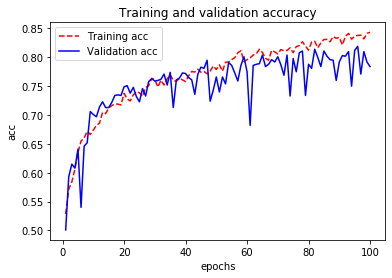

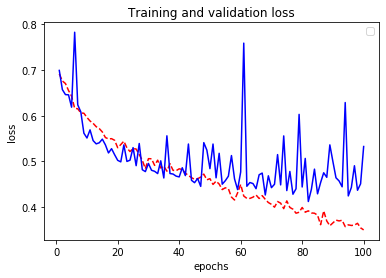

<Figure size 432x288 with 0 Axes>

In [0]:
acc      = historyDA.history['acc' ]
val_acc  = historyDA.history['val_acc']
loss     = historyDA.history['loss' ]
val_loss = historyDA.history['val_loss']

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()



En resumen, en esta sección hemos examinado esta técnica realmente útil que la API Keras ofrece para simular efectivamente un conjunto de datos más grande para entrenar la red neuronal y poder reducir así el problema de sobreentrenamiento.
Aun así, las entradas que ve la red neuronal todavía están muy correlacionadas, ya que provienen de una pequeña cantidad de imágenes originales: no puede producir nueva información, solo puede mezclar la información existente. Como tal, esto puede no ser suficiente para deshacerse por completo del overfitting en algunos casos. Para seguir luchando en la mitigación del sobreentrenamiento se pueden añadir técnicas como la regularización o Dropout, que hemos comentado anteriormente. Pero incluso así, a veces, debido a no tener más datos, no es suficiente para obtener mejores modelos. Para estos casos aún nos queda otra oportunidad, que presentamos en la siguiente sección: usar modelos preentrenados.

# Transfer Learning

Se evidenció cómo aminorar el efecto de un sobreajuste de un modelo con una técnica muy útil para imágenes, como es Data Augmentation. Pero, en realidad, nos encontramos limitados en cuanto a descubrir características de los datos, puesto que si los datos de entrenamiento son muy pocos, al hacer transformaciones con la técnica de Data Augmentation parte de las características de las nuevas imágenes son repeticiones de las anteriores.

## Concepto de Transfer Learning

Transfer Learning es una de las técnicas centrales actualmente en Deep Learning. Su interés radica en que, en lugar de necesitar entrenar una red neuronal desde cero, lo cual implica disponer de una gran cantidad de datos y de mucho tiempo (días o semanas) de computación para entrenar, lo hacemos desde una red preentrenada.

Esta técnica nos permite descargar un modelo de código abierto que alguien ya ha entrenado previamente en un gran conjunto de datos y usar sus parámetros (miles o millones) como punto de partida para, posteriormente, continuar entrenando el modelo con el conjunto de datos (más pequeño) que tengamos para una tarea determinada.

Si el conjunto de datos original con el que se entrenó la red neuronal preentrenada es suficientemente grande y general, entonces la jerarquía espacial de las características (features) aprendidas por la red preentrenada permite al modelo preentrenado actuar como un modelo genérico del mundo visual y, por lo tanto, sus características pueden resultar útiles para muchos problemas diferentes de visión por computadora, a pesar de que estos nuevos problemas pueden involucrar clases completamente diferentes a las de la tarea original

Recordaremos que en una red neuronal convolucional cada capa va aprendiendo diferentes niveles de abstracción, siendo las primeras capas las encargadas de aprender características más genéricas. Estas primeras capas son las que podemos volver a usar fácilmente, puesto que las características aprendidas son aplicables a otros problemas.

Esta «portabilidad» de las características aprendidas a través de diferentes problemas es una de las virtudes clave del Transfer Learning. Específicamente, en el caso de la visión por computador, muchos modelos previamente entrenados (muchos entrenados en el conjunto de datos ImageNet ahora están disponibles públicamente para su descarga y se pueden usar para crear potentes modelos de visión con muy pocos datos.

Hay dos formas de utilizar una red preentrenada, que presentamos a continuación: Feature Extraction y Fine-Tuning.

### Feature Extraction

Feature Extraction consiste en utilizar los parámetros aprendidos por una red preentrenada para extraer características (features) interesantes de nuevos datos.
Estas características obtenidas de los nuevos datos se procesan a través de un nuevo clasificador, que se entrena desde cero.

Las ConvNet utilizadas para clasificar imágenes se componían de dos partes: una serie de capas de convoluciones y pooling, y un clasificador formado habitualmente por una o varias capas densas.

La primera parte se llama base convolucional (convolutional base) del modelo. En el caso de las ConvNet, la extracción de características consiste en tomar la base convolucional de una red previamente entrenada, ejecutar los nuevos datos a través de ella y entrenar a un nuevo clasificador en la parte de la salida.

En la Figura 11.4 se muestra de forma esquemática esta idea. A la izquierda se muestra una ConvNet resaltando sus dos partes, la compuesta por las capas convolucionales y de pooling, y el clasificador final. En la figura del medio resaltamos que de esta ConvNet de base desechamos las capas finales de clasificación y nos quedamos con la primera parte, tanto con su estructura de capas como con los valores de los parámetros (pesos y sesgos de sus neuronas), que llamamos base convolucional. Finalmente, en la figura de la derecha se representa la estructura de la ConvNet que usaremos para clasificar nuestros nuevos datos. A la base convolucional que ya se encuentra entrenada le añadimos las capas finales que se requieran para hacer el clasificador a la medida del problema que estamos tratando. Recordemos que este nuevo clasificador sí que requiere entrenamiento

Representación esquemática de las redes neuronales preentrenadas usadas en la técnica de Feature Extraction.

Resulta muy útil reutilizar la base convolucional porque las características aprendidas por la red preeentrenada de donde se ha extraído son mapas de características de conceptos genéricos sobre una imagen, lo que en general resulta «portable» a otros problemas del mismo ámbito. En general no se reutiliza el clasificador entrenado, ya que las representaciones aprendidas por el clasificador serán necesariamente específicas del conjunto de clases en las que se formó el modelo; solo contendrán información sobre la probabilidad de presencia de esta o aquella clase en la imagen completa.

Además, las representaciones encontradas en capas densamente conectadas ya no mantienen información sobre dónde se encuentran los objetos en la imagen de entrada porque estas capas eliminan la noción de espacio, a diferencia de las capas convolucionales

Lo más interesante para nosotros ahora es que la API de Keras nos permite aplicar esta técnica de una manera muy fácil y con pocas líneas de código.
Keras permite descargar un modelo y luego configurar cómo este debe ser entrenado, indicando qué capas son entrenables (Trainable layers) y qué capas no (Frozen layers).

En general se requieren unas cuantas iteraciones de prueba y error para descubrir la combinación correcta. Concretamente en el caso de visión por computador, muchos modelos preentrenados con ImageNet se encuentran disponibles en la mayoría de librerías de desarrollo de Deep Learning, como es el caso de Keras.

En concreto en la página de modelos preentrenados ``tf.keras.applications172`` podemos encontrar disponibles los siguientes modelos para clasificación de imágenes entrenados con ImageNet:
* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet
* MobileNetV2
* DenseNet
* NASNet

###  VGG16: Modelo con *Feature Extraction*

Se usará la red neuronal VGG16, que tiene una arquitectura convolucional como las que hemos comentado en los capítulos previos.
La red neuronal VGG16 se ha entrenado previamente en un conjunto de datos de ImageNet, que recordemos que tiene 1.4 millones de imágenes en 1000 clases diferentes.
ImageNet contiene muchas clases de animales, incluidas diferentes especies de gatos y perros, por lo que podemos esperar un buen rendimiento en el problema de clasificación de perros contra gatos.
El modelo VGG16 es una red de 16 capas propuesta por Karen Simonyan y Andrew Zisserman en su artículo «Very Deep Convolutional Networks for Large-Scale Image Recognition».

El modelo VGG16 podemos importarlo desde el módulo ``keras.applications``

In [ ]:
from tensorflow.keras.applications import VGG16

A este constructor de la red VGG16 se le pasan tres argumentos.
1. La forma de los tensores de imágenes que alimentarán a la red (es un argumento opcional).
2. El argumento ``include_top`` donde se indica si se debe incluir (o no) el clasificador en la última capa de la red. 
    * Este caso, esta capa corresponde a la capa que clasifica las 1000 clases de ImageNet. Debido a que tenemos la intención de usar nuestro propio clasificador (que clasifica solo dos clases: gato y perro) no necesitamos incluirla.
3. El último argumento, ``weights``, que indica de dónde se obtiene la información para iniciar los pesos de los parámetros de la red (en nuestro caso usaremos ImageNet)

In [0]:
pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

Con el método ``summary()`` podemos saber el detalle de la arquitectura de la base convolucional VGG16:

In [ ]:
pre_trained_model.summary()

Si comparamos con la red neuronal VGG16 completa, se puede comprobar que no existen las dos capas finales fully-connected de 4096 neuronas ni la de 1000 neuronas (cada una de estas neuronas representa una de las categorías de imágenes de ImageNet), las cuales no incluten con el valor **``False``** del argumento ``include_top``

No se necesitan las últimas capas (que son el clasificador de VGG16) porque se crearán unas propias para construir un clasificador y predecir si las imágenes serán un perro o un gato a partir del último feature map de forma y tamaño (4, 4, 512) que nos devuelve la base convolucional VGG16

Importante: Antes de entrenar el modelo es necesario indicar cual de las capas de la base convolucional no deben ser entrenadas, lo que se denomina «congelar» capas (Freeze layers).

Congelar una capa o un conjunto de capas significa evitar que sus pesos se actualicen durante el entrenamiento.
* Si no se hiciera esto, los valores que fueron previamente aprendidos por la base convolucional serían modificados durante el entrenamiento, efecto que no se busca.
* En Keras, congelar una capa se realiza estableciendo su atributo trainable a False:

In [ ]:
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

En Keras los modelos los podemos considerar como capas y, por tanto, podemos agregar un modelo (como pre_trained_model) a un modelo secuencial al igual que agregaríamos una capa:

In [0]:
from tensorflow.keras import Model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
modelFE = Sequential()
modelFE.add(pre_trained_model)
modelFE.add(Flatten())
modelFE.add(Dense(256, activation='relu'))
modelFE.add(Dense(1, activation='sigmoid'))

Así es como el método summary() presenta la red neuronal que se acaba de construir:

In [0]:
modelFE.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Realizamos el preprocesado de **Data Augmentation**

In [0]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

test_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Se compila red utilizando los mismos parametros anteriores

In [0]:
from tensorflow.keras.optimizers import RMSprop

modelFE.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 - 18s - loss: 0.5224 - acc: 0.7305 - val_loss: 0.3127 - val_acc: 0.8760
Epoch 2/100
100/100 - 17s - loss: 0.4142 - acc: 0.8045 - val_loss: 0.3264 - val_acc: 0.8460
Epoch 3/100
100/100 - 17s - loss: 0.3801 - acc: 0.8285 - val_loss: 0.2664 - val_acc: 0.8930
Epoch 4/100
100/100 - 16s - loss: 0.3718 - acc: 0.8265 - val_loss: 0.3015 - val_acc: 0.8660
Epoch 5/100
100/100 - 17s - loss: 0.3528 - acc: 0.8425 - val_loss: 0.2664 - val_acc: 0.8900
Epoch 6/100
100/100 - 17s - loss: 0.3309 - acc: 0.8490 - val_loss: 0.2611 - val_acc: 0.8930
Epoch 7/100
100/100 - 17s - loss: 0.3309 - acc: 0.8470 - val_loss: 0.2519 - val_acc: 0.9000
Epoch 8/100
100/100 - 17s - loss: 0.3192 - acc: 0.8510 - val_loss: 0.2597 - val_acc: 0.8990
Epoch 9/100
100/100 - 16s - loss: 0.3211 - acc: 0.8610 - val_loss: 0.2968 - val_acc: 0.8820
Epoch 10/100
100/100 - 17s - loss: 0.3182 - acc: 0.8520 - val_loss: 0.2802 - va

Se comienza a entrenar el modelo con el método ``fit()``, con la misma configuración de Data Augmentation que utilizamos en la sección anterior.

Pero no es necesariamente siempre la mejor opción; la mejor combinación de técnicas depende del tipo y cantidad de datos disponibles.

In [ ]:
batch_size = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

historyFE = modelFE.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = 100,
            validation_steps = validation_steps,
            verbose = 2)

Comprobar la precisión con los datos de prueba

In [0]:
test_lost, test_acc= modelFE.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

In [0]:
acc      = historyFE.history['acc']
val_acc  = historyFE.history[ 'val_acc']
loss     = historyFE.history['loss']
val_loss = historyFE.history['val_loss']

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
#plt.ylim(0,1)
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')
#plt.ylim(0,1)

plt.legend()
plt.figure()

## Fine-Tuning

Técnica ampliamente utilizada en la reutilización de modelos, complementaria a la Feature Extraction.
Consiste en hacer un ajuste más fino y entrenar también algunas de las capas finales de la base convolucional del modelo usado para la extracción de características (que hasta ahora se mantenía congelada), y entrenar conjuntamente tanto la parte agregada del clasificador como estas capas. Esto se llama Fine-Tuning en nuestro entorno porque se trata de un «ajuste fino» de las representaciones más abstractas del modelo que se está reutilizando como base.

Recordemos que el nivel de generalización y, por lo tanto, de reutilización de las representaciones extraídas por capas de convolución específicas depende de la posición de la capa en el modelo.
* Las primeras capas aprenden características generales y, después, gradualmente en capas sucesivas se van aprendiendo características más concretas del dominio de problema que estamos tratando.
* Las capas del modelo que están más próximas a la capa de entrada de datos extraen mapas de características locales altamente genéricas, mientras que las capas que están más cerca del clasificador final extraen conceptos más abstractos.

Si nos fijamos en el nombre que se le asigna a las capas en la base convolucional VGG16, vemos que se compone de 5 bloques: block1, block2, block3, block4, block5.

Para mostrar la técnica de Fine-Tuning se entrenará el block5 compuesto por tres capas convolucionales y una de pooling (block5_conv1, block5_conv2 y block5_conv3 serán ahora entrenables

### VGG16 : Modelo con *Fine Tuning*

El código en Keras que permite especificar este comportamiento en la fase de entrenamiento que acabamos de describir puede ser el siguiente:

In [0]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')

pre_trained_model.trainable = True

set_trainable = False


for layer in pre_trained_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable: 
        layer.trainable = True
    else:
        layer.trainable = False

pre_trained_model.summary()

Definamos igual que antes la red:

In [0]:
modelFT = Sequential()
modelFT.add(pre_trained_model)
modelFT.add(Flatten())
modelFT.add(Dense(256, activation='relu'))
modelFT.add(Dense(1, activation='sigmoid'))

Ahora el pre_trained_model tendrá más capas a entrenar, como podemos ver con la salida del método summary()

In [ ]:
modelFT.summary()

#### Compilación y entrenamiento de la red

Se usarán los mismos hiperparámetros (optimizador RMSProp con learning rate de 1e-4), pero es importante dejar claro, para aquellos que quieran profundizar más en el tema, que estos hiperparámetros juegan un papel fundamental.
* En general es una buena práctica usar un learning rate muy pequeño para limitar la magnitud de las modificaciones que se realizan en las tres capas del block5 que está ajustando.
* Los learning rate que son demasiado grandes pueden dañar los pesos previos que venían de la red preentrenada, ya que mantenían información importante para representar a las características.

In [0]:
from tensorflow.keras.optimizers import RMSprop

modelFT.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), 
              metrics=['acc'])

Generación del conjunto de datos aumentados

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


test_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Entrenamiento del modelo

In [0]:
batch_size = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

historyFT = modelFT.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 100,
    validation_steps = validation_steps,
    verbose = 2)

Igual que en los anteriores modelos, se verifica gráficamente cómo evoluciona el entrenamiento en las gráficas

In [0]:
import matplotlib.pyplot as plt

acc      = historyFT.history['acc']
val_acc  = historyFT.history['val_acc']
loss     = historyFT.history['loss']
val_loss = historyFT.history['val_loss']

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
#plt.ylim(0,1)
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')
plt.ylim(0,1)

plt.legend()
plt.figure()

Con los datos de pruebapara confirmar la mejora observada ya en el historial de entrenamiento

In [0]:
test_lost, test_acc= modelFT.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

In [0]:
accDA      = historyDA.history['acc']
val_accDA  = historyDA.history['val_acc']

accFE      = historyFE.history['acc']
val_accFE  = historyFE.history['val_acc']

accFT      = historyFT.history['acc']
val_accFT  = historyFT.history['val_acc']

epochs    = range(1,len(accDA)+1,1) 

plt.figure(figsize=(10,18))

plt.plot  ( epochs,     accFT, 'k', label='Fine Tuning - Training acc '  )
plt.plot  ( epochs, val_accFT,  'b', label='Fine Tuning - Validation acc ')

plt.plot  ( epochs,     accFE, 'r--', label='Feature Extraction - Training acc'  )
plt.plot  ( epochs, val_accFE,  'm--', label='Feature Extraction - Validation acc')

plt.plot  ( epochs,     accDA, 'g:', label='Data Augmentation - Training acc'  )
plt.plot  ( epochs, val_accDA,  'c:', label='Data Augmentation - Validation acc')

plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.ylim(0.5,1)
plt.xlabel('epochs')


plt.legend()
plt.figure()

Prueba con fotografías propias

In [0]:
import numpy as np

from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded=files.upload()
file=list(uploaded.keys())[0]

path='/content/' + file
img=image.load_img(path, target_size=(150, 150))

x=image.img_to_array(img)
image=np.expand_dims(x, axis=0)  

classes = model.predict(image)
print(classes)

plt.imshow(img)
plt.show()

if classes>0: print( fn + " es un PERRO")
else: print( fn + " es un GATO")